
Training with Adam optimizer...
Epoch 1/3
73/73 ━━━━━━━━━━━━━━━━━━━━ 397s 5s/step - loss: 0.0742 - val_loss: 0.0710
Epoch 2/3
73/73 ━━━━━━━━━━━━━━━━━━━━ 391s 5s/step - loss: 0.0723 - val_loss: 0.0759
Epoch 3/3
73/73 ━━━━━━━━━━━━━━━━━━━━ 397s 5s/step - loss: 0.0751 - val_loss: 0.0695



Training with SGD optimizer...
Epoch 1/3
73/73 ━━━━━━━━━━━━━━━━━━━━ 391s 5s/step - loss: 0.0757 - val_loss: 0.0768
Epoch 2/3
73/73 ━━━━━━━━━━━━━━━━━━━━ 401s 5s/step - loss: 0.0752 - val_loss: 0.0783
Epoch 3/3
73/73 ━━━━━━━━━━━━━━━━━━━━ 393s 5s/step - loss: 0.0765 - val_loss: 0.0733



Training with RMSprop optimizer...
Epoch 1/3
73/73 ━━━━━━━━━━━━━━━━━━━━ 399s 5s/step - loss: 0.0748 - val_loss: 0.0705
Epoch 2/3
73/73 ━━━━━━━━━━━━━━━━━━━━ 398s 5s/step - loss: 0.0719 - val_loss: 0.0758
Epoch 3/3
73/73 ━━━━━━━━━━━━━━━━━━━━ 397s 5s/step - loss: 0.0722 - val_loss: 0.0697


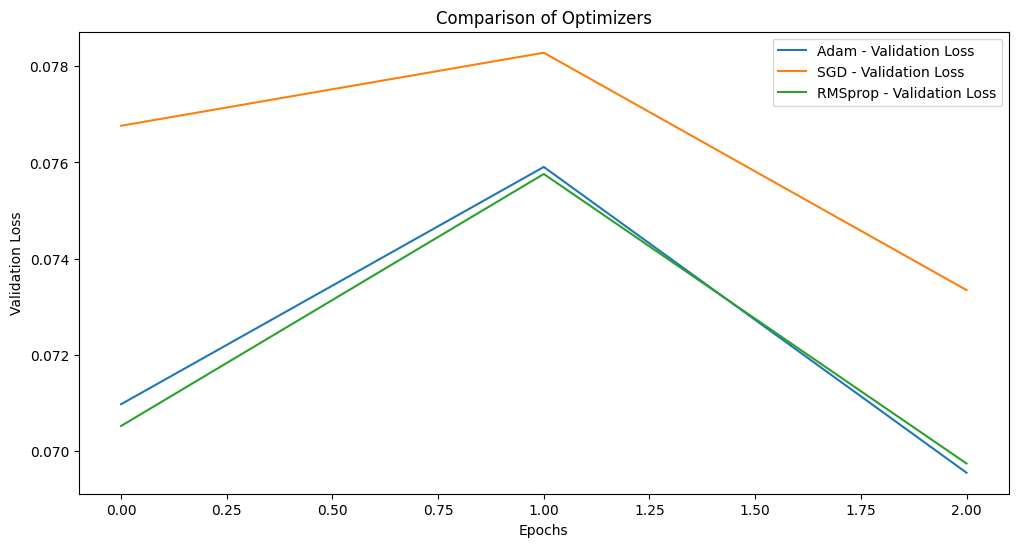

In [6]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import Sequence
from tensorflow.keras.layers import Conv2D, UpSampling2D, Cropping2D, InputLayer
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.models import Sequential
import matplotlib.pyplot as plt

class ColorizationDataGenerator(Sequence):
    def __init__(self, grayscale_dir, colorized_dir, batch_size, target_size, shuffle=True):
        self.grayscale_dir = grayscale_dir
        self.colorized_dir = colorized_dir
        self.batch_size = batch_size
        self.target_size = target_size
        self.shuffle = shuffle

        self.grayscale_images = os.listdir(grayscale_dir)
        self.colorized_images = os.listdir(colorized_dir)

        # Shuffle the images if required
        if self.shuffle:
            np.random.shuffle(self.grayscale_images)

    def __len__(self):
        # Returns the number of batches per epoch
        return int(np.floor(len(self.grayscale_images) / self.batch_size))

    def on_epoch_end(self):
        # Shuffle the data at the end of each epoch
        if self.shuffle:
            np.random.shuffle(self.grayscale_images)

    def __getitem__(self, index):
        # Generate one batch of data
        batch_grayscale = self.grayscale_images[index * self.batch_size:(index + 1) * self.batch_size]
        batch_colorized = self.colorized_images[index * self.batch_size:(index + 1) * self.batch_size]

        # Load images into arrays
        grayscale_images = np.zeros((self.batch_size, *self.target_size, 1), dtype=np.float32)
        colorized_images = np.zeros((self.batch_size, *self.target_size, 3), dtype=np.float32)

        for i, grayscale_img in enumerate(batch_grayscale):
            grayscale_path = os.path.join(self.grayscale_dir, grayscale_img)
            colorized_path = os.path.join(self.colorized_dir, batch_colorized[i])

            # Load and resize grayscale image (1 channel)
            grayscale_image = load_img(grayscale_path, target_size=self.target_size, color_mode='grayscale')
            grayscale_image = img_to_array(grayscale_image) / 255.0  # Normalize to [0, 1]

            # Load and resize colorized image (3 channels)
            colorized_image = load_img(colorized_path, target_size=self.target_size, color_mode='rgb')
            colorized_image = img_to_array(colorized_image) / 255.0  # Normalize to [0, 1]

            grayscale_images[i] = grayscale_image
            colorized_images[i] = colorized_image

        return grayscale_images, colorized_images

# Define the directories
train_grayscale_dir = 'cv_p3_images_split/train/grayscale/'
train_colorized_dir = 'cv_p3_images_split/train/colored/'
val_grayscale_dir = 'cv_p3_images_split/validation/grayscale/'
val_colorized_dir = 'cv_p3_images_split/validation/colored/'

# Create the generators
train_generator = ColorizationDataGenerator(
    grayscale_dir=train_grayscale_dir,
    colorized_dir=train_colorized_dir,
    batch_size=16,  #Reduced batch size
    target_size=(256, 256)
)

validation_generator = ColorizationDataGenerator(
    grayscale_dir=val_grayscale_dir,
    colorized_dir=val_colorized_dir,
    batch_size=16,  # Reduced batch size
    target_size=(256, 256)
)

# Define the model
def create_model():
    model = Sequential([
        InputLayer(input_shape=(256, 256, 1)),  # Grayscale input
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        UpSampling2D((2, 2)),  # Upsample to 512x512
        Conv2D(32, (3, 3), activation='relu', padding='same'),
        Conv2D(16, (3, 3), activation='relu', padding='same'),
        Conv2D(3, (3, 3), activation='sigmoid', padding='same'),  # Output of size 256x256
        Cropping2D(cropping=((128, 128), (128, 128)))
    ])
    return model

# Optimizers to test
optimizers = {
    "Adam": Adam(learning_rate=0.001),
    "SGD": SGD(learning_rate=0.001, momentum=0.9),
    "RMSprop": RMSprop(learning_rate=0.001)
}

# Train and evaluate the model with different optimizers
results = {}

for optimizer_name, optimizer in optimizers.items():
    print(f"\nTraining with {optimizer_name} optimizer...")
    
    # Create the model
    model = create_model()
    
    # Compile the model with the current optimizer
    model.compile(optimizer=optimizer, loss='mean_squared_error')

    # Train the model
    history = model.fit(
        train_generator,
        validation_data=validation_generator,
        epochs=3,  # Reduced number of epochs
        steps_per_epoch=len(train_generator) // 5,  # Use 1/5 of the data
        validation_steps=len(validation_generator) // 5,  # Use 1/5 of the data
        verbose=1
    )
    
    # Store the results
    results[optimizer_name] = history.history

    # Save the model for later use
    model.save(f'colorization_model_{optimizer_name}.h5')

# Plot the results
plt.figure(figsize=(12, 6))
for optimizer_name, history in results.items():
    plt.plot(history['val_loss'], label=f'{optimizer_name} - Validation Loss')

plt.title('Comparison of Optimizers')
plt.xlabel('Epochs')
plt.ylabel('Validation Loss')
plt.legend()
plt.show()
